In [4]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

## Create Dataset
- *Data created from sklearn dataset using [make_blob()](https://scikit-learn.org/1.6/modules/generated/sklearn.datasets.make_blobs.html) functions*
- *Split the dataset into train (80%) and test (20%)*


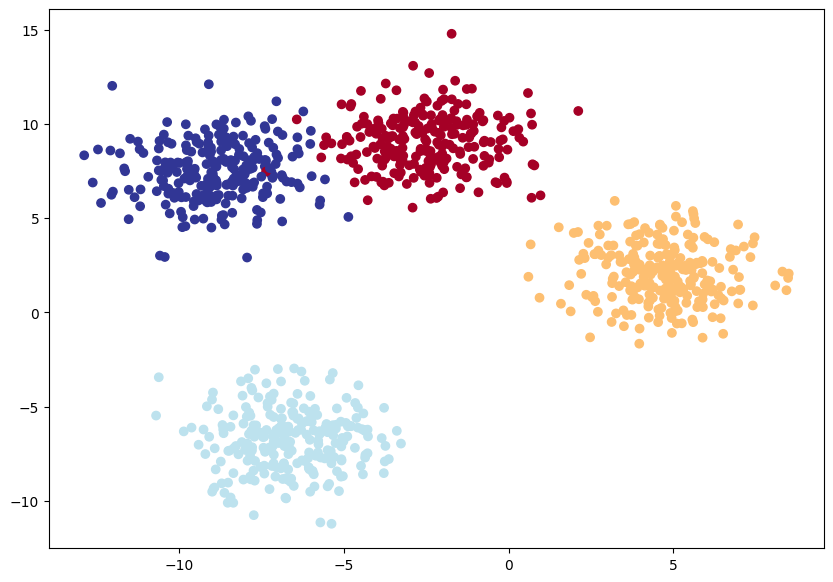

In [23]:
# Set the hyperparameters for dataset creation

NUM_FEATURES = 2
NUM_CLASSES = 4
RANDOM_SEED = 42

# Make the data
X_blob, y_blob = make_blobs(n_samples=1000, 
                            n_features=NUM_FEATURES, 
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# Make the data tensor format
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split the dataset
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, 
                                                                        y_blob, 
                                                                        test_size=0.2, random_state=RANDOM_SEED)
# Plot the dataset
plt.figure(figsize=(10,7))
plt.scatter(x=X_blob[:,0], 
            y=X_blob[:,1], 
            c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [25]:
# Creating Multiclass Classification Model
class MulticlassClassificationModelV0(nn.Module):
    def __init__(self, input_features:int, output_features:int, hidden_units:int=8):
        """Initialization multiclass classification model

        Args:
          input_features (int): Number of input features of the model (features number).
          output_features (int): number of output features of the model. (number of classes)
          hidden_units (int): number of hidden units default is 8
        
        Returns:

        Example:
        """
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
        
    def forward(self, x:torch.Tensor):
        return self.linear_stack(x)

# Create model instance
model_0 = MulticlassClassificationModelV0(input_features=2, 
                                          output_features=4, 
                                          hidden_units=8).to(device)
model_0

MulticlassClassificationModelV0(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [26]:
# Create a loss function for multi-class classification - loss function measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [27]:
# Setup the accuracy function

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [22]:
# Now see some raw outputs before train the model

model_0.eval()
with torch.inference_mode():
    y_blob_untrained_logits = model_0(X_blob_test.to(device))
y_blob_untrained_logits[:5,]

tensor([[-0.5314, -0.2787,  0.1220, -0.7259],
        [-0.1863, -0.7356,  0.1938, -0.7049],
        [-0.3292, -0.4494, -0.5334,  0.1339],
        [-0.1601, -0.3213,  0.2821, -0.4246],
        [-0.8173, -0.5035, -0.2100, -0.9648]], device='cuda:0')

In [29]:
# Training Start:

# Setup manual seed
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Setup total epochs
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)


# Run the traing loop untill the total epochs
for epoch in range(epochs):
    model_0.train()

    y_blob_logits = model_0(X_blob_train)
    y_blob_preds = torch.softmax(y_blob_logits, dim=1).argmax(dim=1)

    train_loss = loss_fn(y_blob_logits, y_blob_train)
    train_acc = accuracy_fn(y_true=y_blob_train, y_pred=y_blob_preds)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        test_blob_logits = model_0(X_blob_test)
        test_blob_preds = torch.softmax(test_blob_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_blob_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_blob_preds)
        
    # Print out what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")
     

Epoch: 0 | Train Loss: 1.4072, Train Acc: 27.88% | Test loss: 1.2691, Test acc: 29.50%
Epoch: 10 | Train Loss: 0.5212, Train Acc: 94.12% | Test loss: 0.4525, Test acc: 98.00%
Epoch: 20 | Train Loss: 0.2017, Train Acc: 99.12% | Test loss: 0.1834, Test acc: 100.00%
Epoch: 30 | Train Loss: 0.1085, Train Acc: 99.38% | Test loss: 0.0993, Test acc: 99.50%
Epoch: 40 | Train Loss: 0.0735, Train Acc: 99.25% | Test loss: 0.0662, Test acc: 99.50%
Epoch: 50 | Train Loss: 0.0571, Train Acc: 99.25% | Test loss: 0.0501, Test acc: 99.50%
Epoch: 60 | Train Loss: 0.0480, Train Acc: 99.25% | Test loss: 0.0410, Test acc: 99.50%
Epoch: 70 | Train Loss: 0.0424, Train Acc: 99.12% | Test loss: 0.0351, Test acc: 99.50%
Epoch: 80 | Train Loss: 0.0385, Train Acc: 99.12% | Test loss: 0.0311, Test acc: 99.50%
Epoch: 90 | Train Loss: 0.0358, Train Acc: 99.12% | Test loss: 0.0281, Test acc: 99.50%


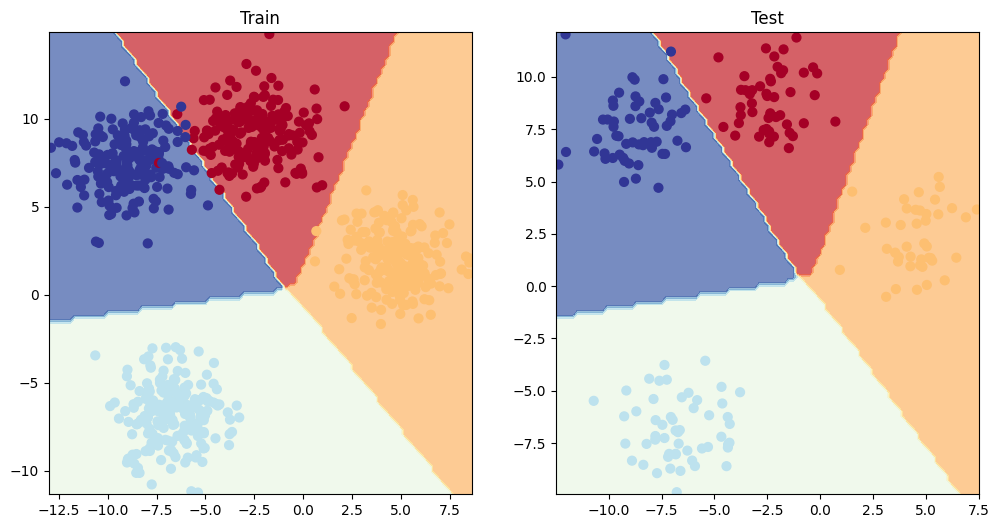

In [32]:
from helper_functions import plot_predictions, plot_decision_boundary
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_blob_test, y_blob_test) 